In [23]:
import sys
import pandas as pd
sys.path.insert(0, 'C:/Udvikler/Speciale/SpecialeKode')
from utils import *
from DeepRL.datatransformer import DataTransformerDeep
from model_evaluation.RFQModelEval import RFQModelEval, eval_utils
from ContextualRFQAgent import ContextualRFQAgent

In [24]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#Not to make the kernel crash
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [25]:
# Read the CSV file into a pandas DataFrame
file_path = "../data/data_inventory_risk.csv"
df = pd.read_csv(file_path)

# Datetime format
df["TradeTime"] = pd.to_datetime(df["TradeTime"], format="%m/%d/%Y %H:%M:%S")

#Split into train and test set  
train_df, val_df = split_data(df, 0.8)

#Further split test into val and test, to make model selection
#val_df, test_df = split_data(test_df.copy(), 0.5)


In [26]:
import itertools

all_features = [
    #["DealersInCompetition", "FirmAccount", "IssuedAmount", "Oas", "BidAskSpread", "Side", "BookName", "KeyRatioPrice", "AllQMinMid", "AllQMaxMid", "AllQMeanMid", "MarketThicknes"],
    #["DealersInCompetition", "FirmAccount", "Side", "BookName", "AllQMeanMid", "Oas", "IssuedAmount"],
    #["FirmAccount", "Oas", "BookName", "AllQMeanMid"],
    #["DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["DealersInCompetition", "FirmAccount", "BookName", "AllQMeanMid"],
    #["FirmAccount", "Oas", "BookName", "Amount", "AllQMeanMid"],
    #["inventoryRisk", "FirmAccount", "Oas", "BookName", "AllQMeanMid"],
    #["bpv_risk", "FirmAccount", "Oas", "BookName", "AllQMeanMid"],
    #["KeyRatioPrice", "BookName", "AllQMeanMid"],
    #["bpv_risk", "DealersInCompetition", "BookName", "AllQMeanMid", "Mid"], Glem mid, giver ingenting!
    #["DealersInCompetition", "Amount", "BookName", "AllQMeanMid"]
    ["bpv_risk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["inventoryRisk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"]
]

all_reward_functions = [
    #simpleSpreadReward,
    linearMarginReward,
    quadraticMarginReward,
    inventory_PnL_reward,
    risk_PnL_reward
]

learning_algorithms = [
    "action_classifier"
    #"reward_regression"
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
           "meanMLSharpeRatio", "meanDealerSharpeRatio"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm)
     for features, reward_function, learning_algorithm in itertools.product(all_features_str, all_reward_functions, learning_algorithms)],
    names=["Features", "Reward Function", "Learning Algorithm"]
)

# Initialize an empty DataFrame with the MultiIndex
results_df = pd.DataFrame(columns=metrics, index=index)

# Iterate over all combinations and collect results
for features, reward_function, learning_algorithm in itertools.product(all_features, all_reward_functions, learning_algorithms):
    # Convert features list to a single string
    features_key = ",".join(features)  # Join list of strings with commas
    key = (features_key, reward_function.__name__, learning_algorithm)

    print(f"Combination: {key} \n")
    
    opponent_actions = learning_algorithm in [""] 
    discretize_actions = False if learning_algorithm == "" else True

    # Perform the experiment (replace with your actual code)
    data_transformer = DataTransformerDeep(
        input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15,
        reward_function=reward_function, opponent_actions=opponent_actions, discretize_actions=discretize_actions, reward_terms=False)
    
    agent = ContextualRFQAgent(data_transformer=data_transformer)
    agent.train(train_df.copy(), algorithm=learning_algorithm)

    modelEvaluator = RFQModelEval(agent)
    modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=False, print_violin_plot=False)
    
    # Collect and store the relevant metrics
    results_df.loc[key] = modelPerformance[metrics]  # Example of storing mean values

# Display the results DataFrame
print(results_df)

Combination: ('bpv_risk,Side,DealersInCompetition,BookName,AllQMeanMid', 'linearMarginReward', 'action_classifier') 

Desired HR: 23.61855910468641 

Combination: ('bpv_risk,Side,DealersInCompetition,BookName,AllQMeanMid', 'quadraticMarginReward', 'action_classifier') 

Desired HR: 23.61855910468641 

Combination: ('bpv_risk,Side,DealersInCompetition,BookName,AllQMeanMid', 'inventory_PnL_reward', 'action_classifier') 

Desired HR: 23.61855910468641 

Combination: ('bpv_risk,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'action_classifier') 

Desired HR: 23.61855910468641 

Combination: ('inventoryRisk,Side,DealersInCompetition,BookName,AllQMeanMid', 'linearMarginReward', 'action_classifier') 

Desired HR: 23.61855910468641 

Combination: ('inventoryRisk,Side,DealersInCompetition,BookName,AllQMeanMid', 'quadraticMarginReward', 'action_classifier') 

Desired HR: 23.61855910468641 

Combination: ('inventoryRisk,Side,DealersInCompetition,BookName,AllQMeanMid', 'invent

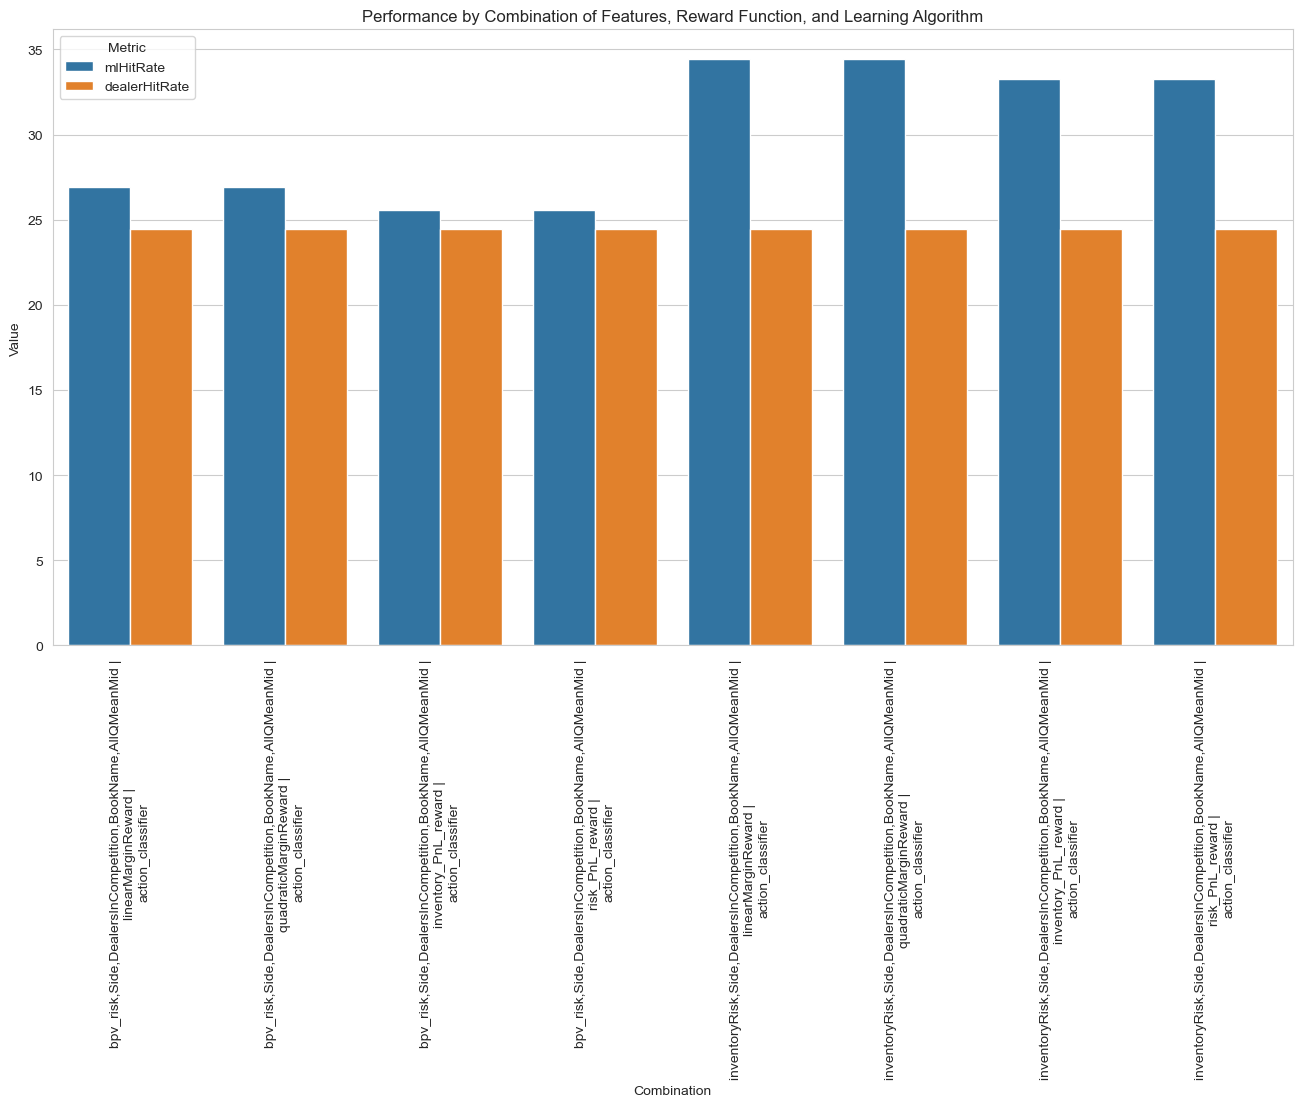

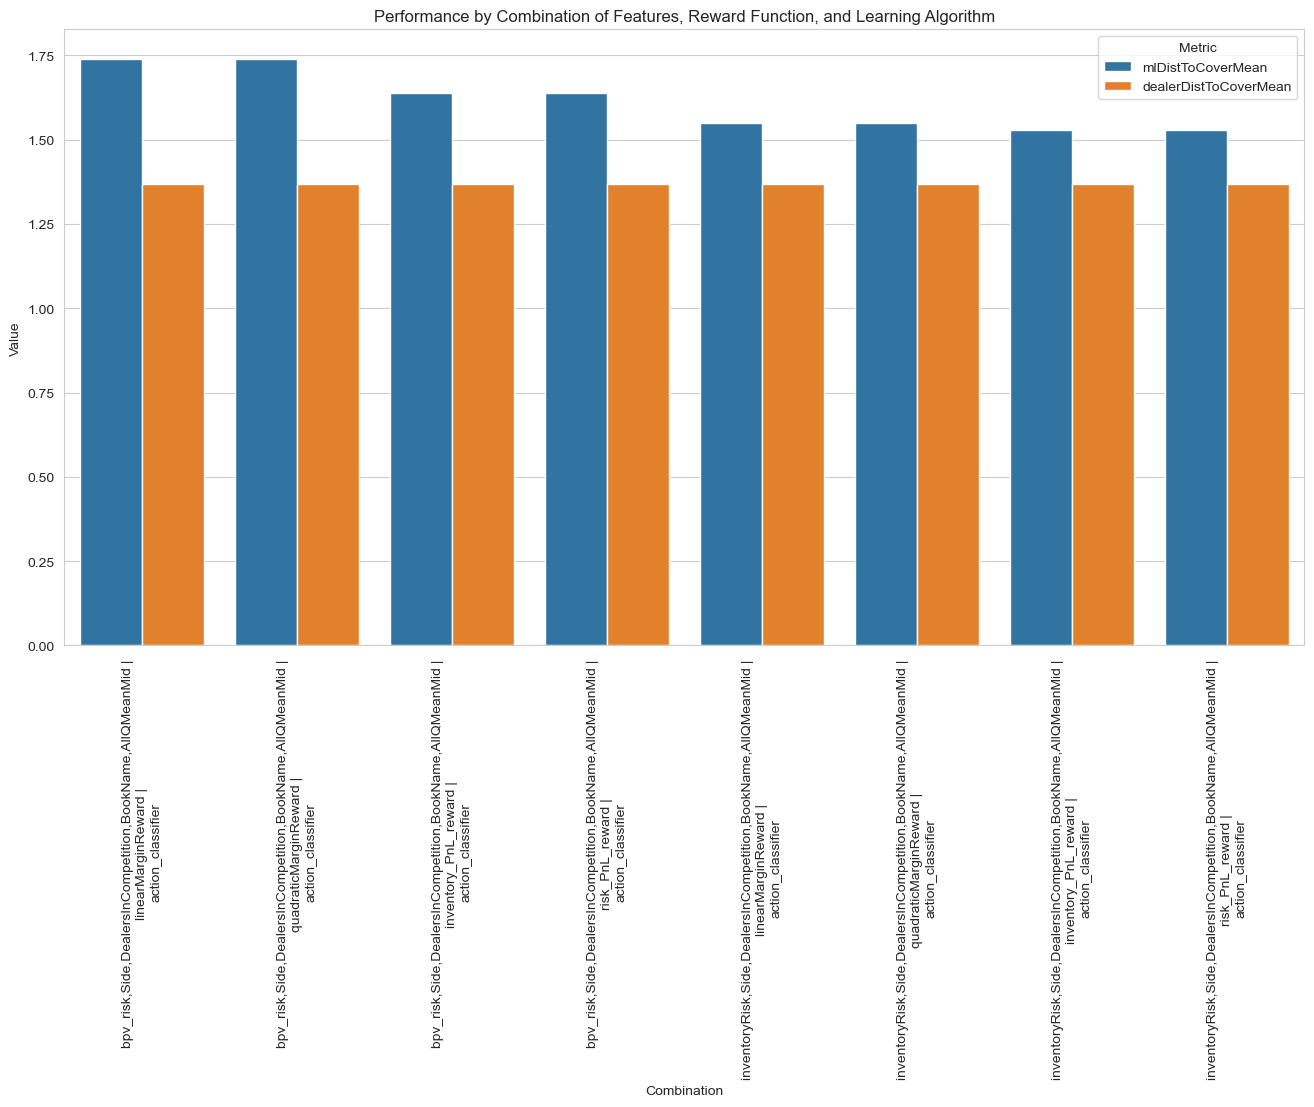

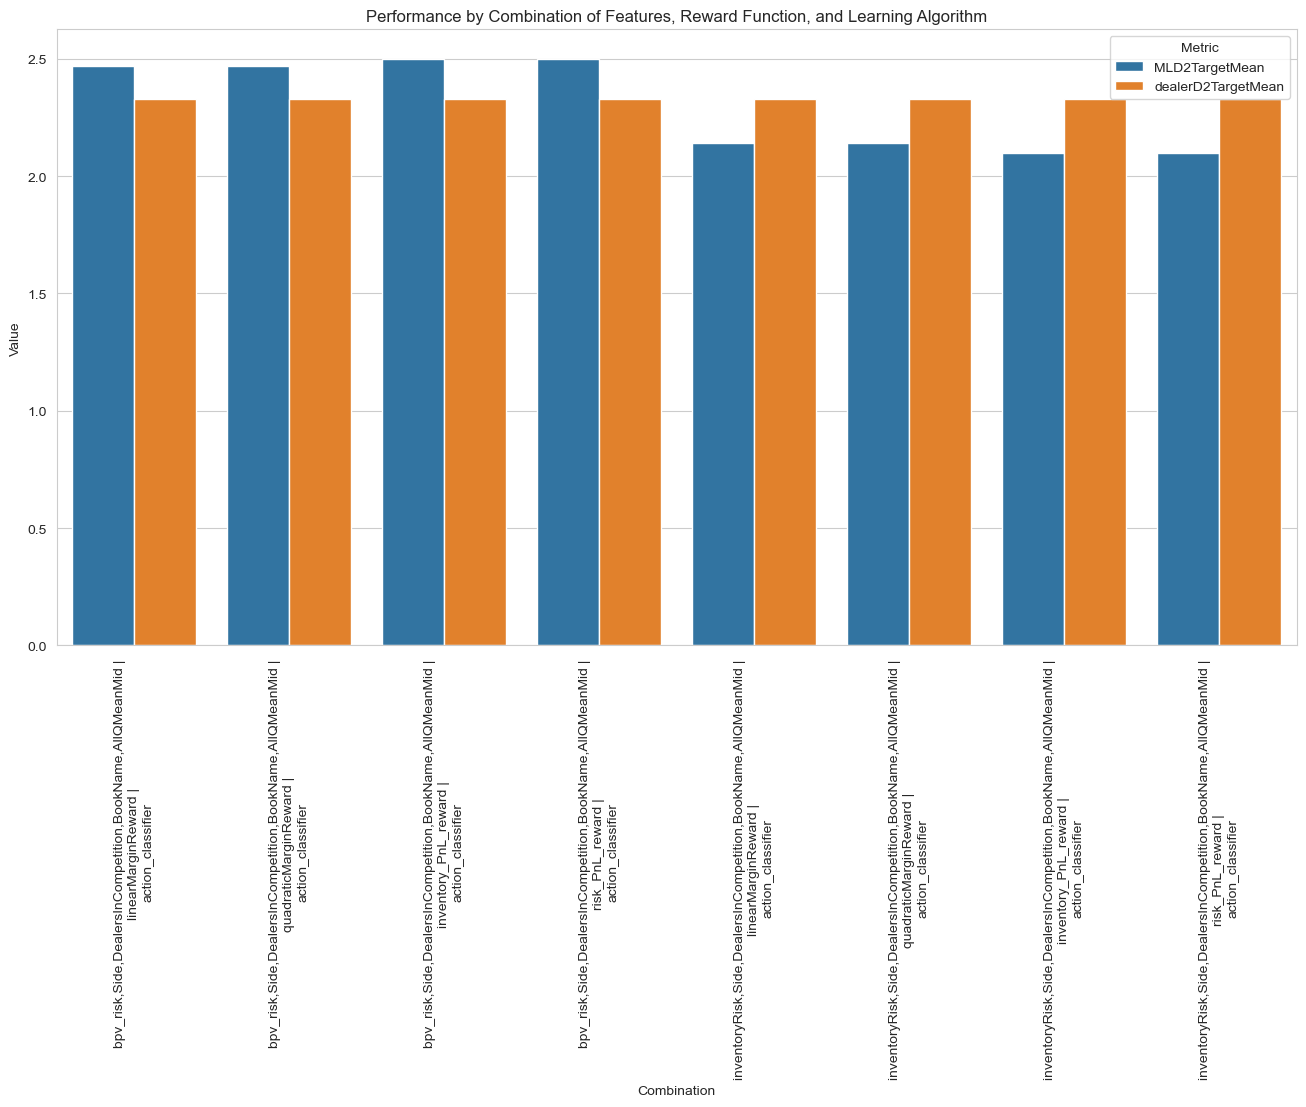

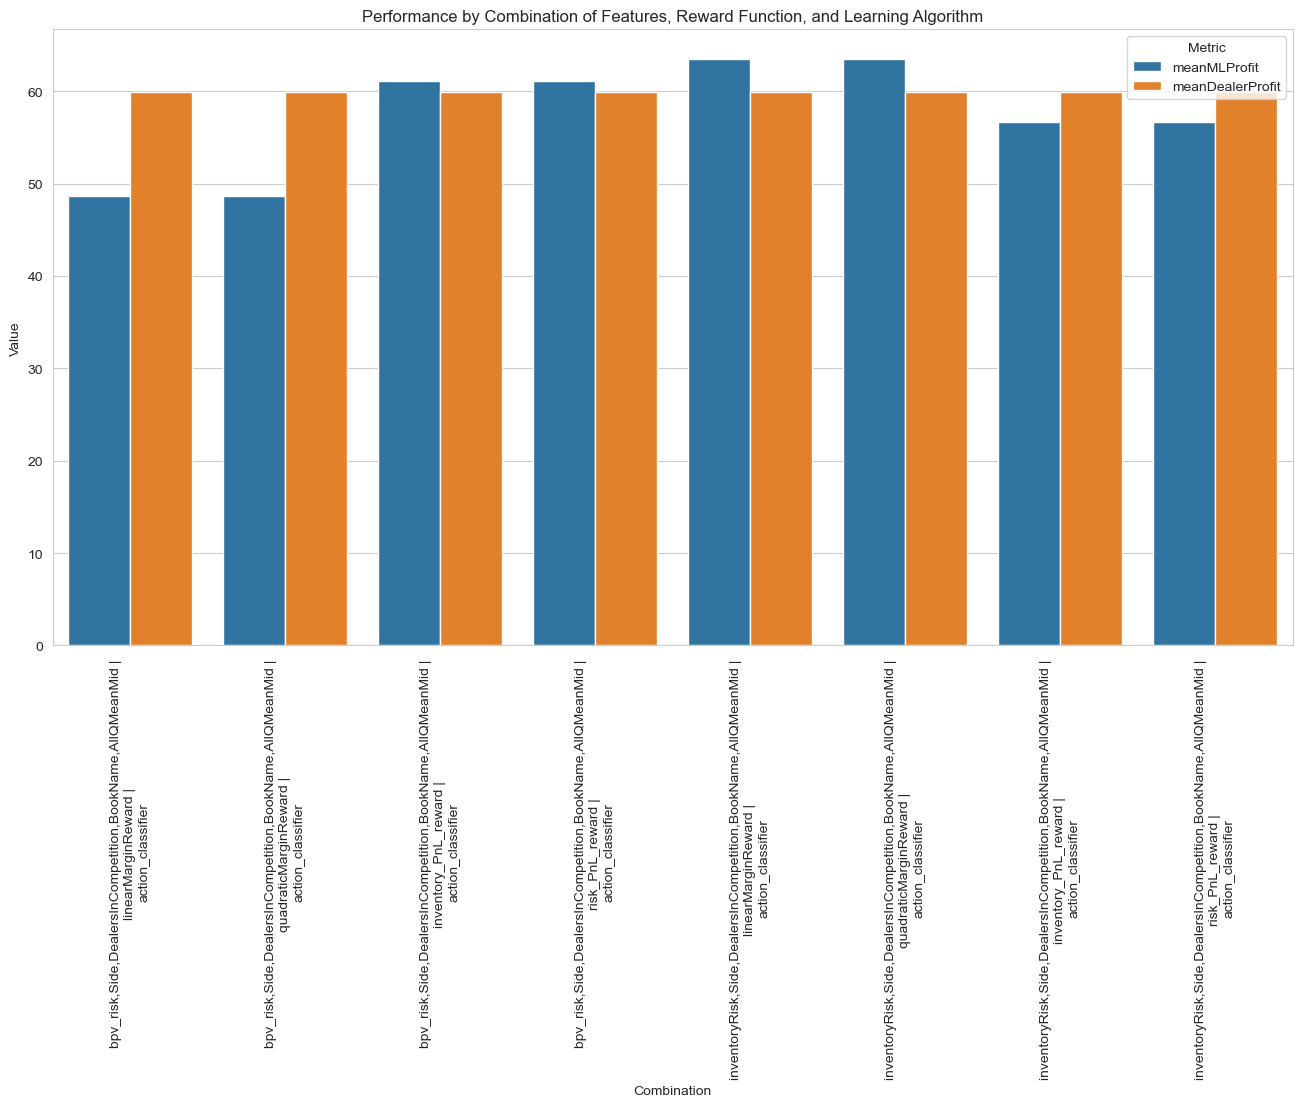

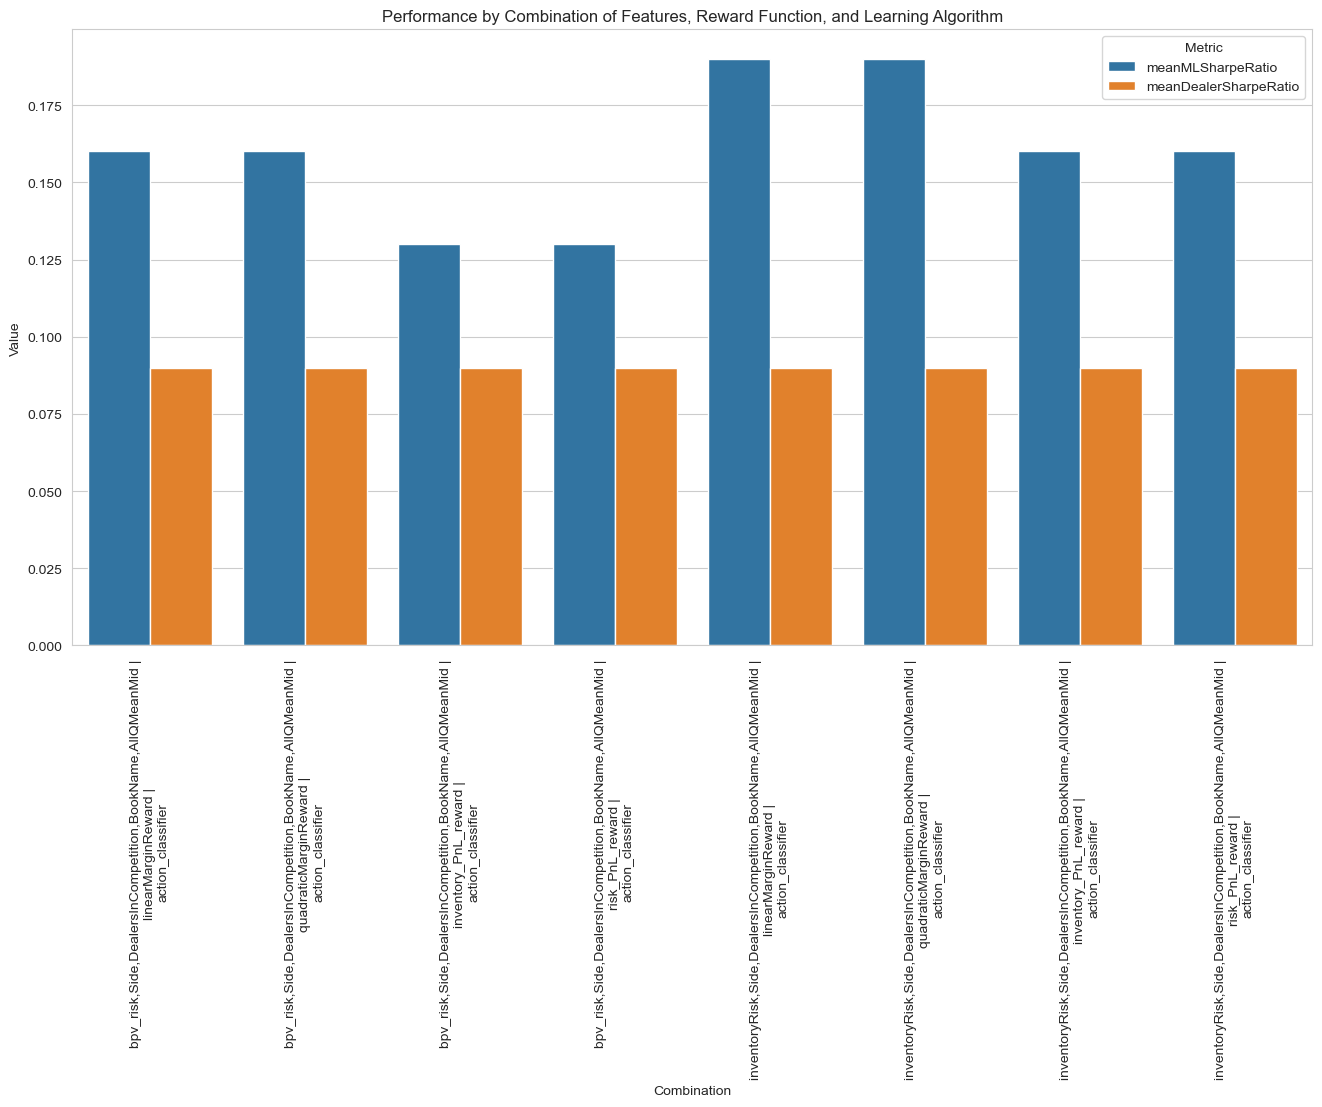

In [27]:
eval_utils.visualize_trader_vs_ML_metrics(results_df=results_df.copy(), deepRL=False)

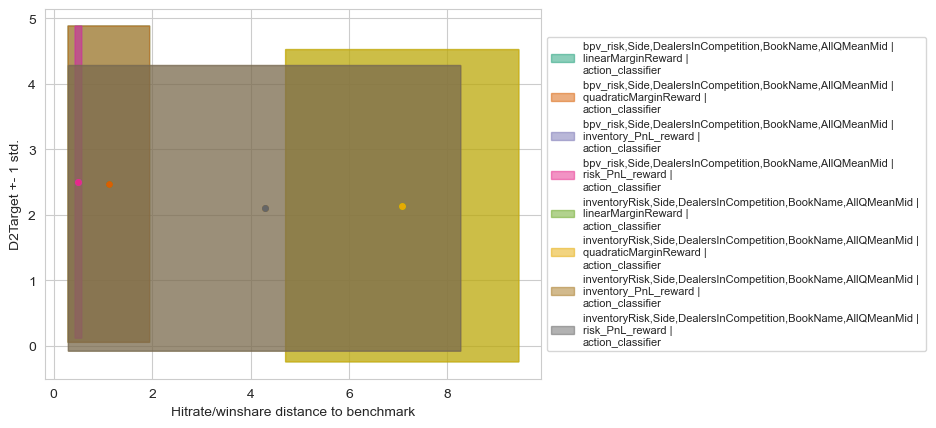

In [28]:
eval_utils.convex_hull(results_df.copy(), distance_measure="Target", deepRL=False)